In [31]:
# Data management
import pandas as pd
import numpy as np

# Network
import networkx as nx

# Data 
import itertools
from collections import Counter

# Graphes
import matplotlib.pyplot as plt
%matplotlib inline

# Utilitaires
from jyquickhelper import add_notebook_menu
import os

In [32]:
add_notebook_menu()

# Authors Graph

This notebook aims at structuring the co-authors data to build the related graph

## Load dataset

In [33]:
# Path to the data
#path = "C://Users//Dimitri//Desktop//ENSAE3A//NetworkData//Tables//"
path= os.path.join(os.getcwd(),"Tables")
# Load the data
attrs_nos = pd.read_csv(path + "/attrs_nos.csv", encoding = "ISO-8859-1")

In [34]:
# Print the data
attrs_nos.head()

,url,title,authors,date,jel_code,keywords,editor,journal,article_id,authors_list,authors_nos
0,https://ideas.repec.org/a/oup/qjecon/v1y1886i1...,The Reaction in Political Economy,Charles F. Dunbar,1886-02-02,NaN,NaN,oup,qjecon,v1y1886i1p1-27..html,['Charles F. Dunbar'],[6160]
1,https://ideas.repec.org/a/oup/qjecon/v1y1886i1...,Private Monopolies and Public Rights,Arthur T. Hadley,1886-02-02,NaN,NaN,oup,qjecon,v1y1886i1p28-44..html,['Arthur T. Hadley'],[3334]
2,https://ideas.repec.org/a/oup/qjecon/v1y1886i1...,Silver Before Congress in 1886,S. Dana Horton,1886-02-02,NaN,NaN,oup,qjecon,v1y1886i1p45-75..html,['S. Dana Horton'],[36527]
3,https://ideas.repec.org/a/oup/qjecon/v1y1886i1...,"The Arithmetic, Geometric, and Harmonic Means",F. Coggeshall,1886-02-02,NaN,NaN,oup,qjecon,v1y1886i1p83-86..html,['F. Coggeshall'],[11962]
4,https://ideas.repec.org/a/oup/qjecon/v1y1886i1...,Legislation for Labor Arbitration,H. M. Williams,1886-02-02,NaN,NaN,oup,qjecon,v1y1886i1p86-91..html,['H. M. Williams'],[15170]


## Preprocess data

In [35]:
print("Elements of the {0} authors_nos are {1} with '{2}' as 0th element".\
      format(type(attrs_nos.authors_nos), type(attrs_nos.authors_nos[0]), attrs_nos.authors_nos[0][0]))

Elements of the <class 'pandas.core.series.Series'> authors_nos are <class 'str'> with '[' as 0th element


In [36]:
def str_to_list(x):
    """
    Interpret strings of the form "['int1', 'int2']" as the list [int1, int2]
    
    Params:
        x (str) : the string to interpret
    Returns:
        list : the output list
    """
    x = x.replace("[", "")
    x = x.replace("]", "")
    splitted = x.split(", ")
    no_list = [int(i) for i in splitted]
    return no_list 

In [37]:
# Interpret "author_nos" column as a list of numbers of authors
attrs_nos["authors_nos"] = attrs_nos["authors_nos"].apply(str_to_list)

In [38]:
attrs_nos.authors_nos.head()

0     [6160]
1     [3334]
2    [36527]
3    [11962]
4    [15170]
Name: authors_nos, dtype: object

In [39]:
print("Elements of the {0} authors_nos are now a {1} of {2}".\
      format(type(attrs_nos.authors_nos), type(attrs_nos.authors_nos[0]), type(attrs_nos.authors_nos[0][0])))

Elements of the <class 'pandas.core.series.Series'> authors_nos are now a <class 'list'> of <class 'int'>


## Build the author graph

### Edges list

In [40]:
def get_edges_list(auths_nums):
    """
    Get list of edges between authors from a series of list of authors 
    (each entry of the series are the authors of a given article).
    
    Params:
        auths_nums (pandas.core.series.Series) : the series of list of authors
        
    Returns:
        list : a list of tuples with possibly redundant tuples
        
    WARNING: Does not retain articles with only one author 
    """
    edges_list = []
    auths_nums_reduced = auths_nums[auths_nums.apply(lambda x: len(x)) > 1]
    for auth_list in auths_nums_reduced:
        combinations = list(itertools.combinations(auth_list, 2))
        edges_list += combinations
    return edges_list         

In [41]:
# Get list of edges
auths_nos = attrs_nos["authors_nos"].copy()
edges_list = get_edges_list(auths_nos)
# Print it
print(edges_list[:100])

[(1499, 17717), (41344, 36583), (10735, 4646), (10803, 31109), (18361, 42689), (13297, 42309), (17631, 31109), (18361, 42689), (162, 31109), (162, 31109), (23621, 31109), (43065, 42145), (43065, 42055), (43065, 17596), (42145, 42055), (42145, 17596), (42055, 17596), (16068, 35902), (31109, 39650), (23176, 16343), (32779, 23940), (11896, 42074), (31109, 15103), (523, 31109), (12760, 39624), (5660, 12272), (17693, 20443), (15877, 20774), (33761, 3320), (162, 29101), (162, 29624), (29101, 29624), (11952, 15715), (13030, 10516), (13030, 198), (10516, 198), (40061, 42519), (20443, 42051), (25091, 20774), (15864, 11112), (26810, 31693), (42539, 20443), (26810, 31693), (35075, 4077), (17564, 42051), (17564, 30544), (42051, 30544), (11146, 36210), (15651, 34887), (20443, 42539), (14609, 31693), (22079, 24574), (17287, 215), (17287, 10443), (215, 10443), (6115, 11780), (22079, 24574), (14609, 31693), (6087, 42123), (39661, 30555), (42123, 6087), (30484, 27963), (10358, 13479), (11892, 34318), (

### Weighted edges list

In [42]:
def sort_edges(edges_list):
    """
    For all tuples in edges_list, put the lowest number in the first place and then sort the whole list.
    
    Params:
        edges_list (list) : list of tuples representing the authors pairs
    
    Returns:
        list : a list of tuples after the two sorting steps described above
    
    """
    sorted_edges_list = []
    for edge in edges_list:
        edge_l = list(edge)
        edge_l.sort()
        sorted_edges_list.append(tuple(edge_l))
    sorted_edges_list.sort()
    return sorted_edges_list

In [43]:
# Sort list of edges
s_edges_list = sort_edges(edges_list)
# Print the result
print(s_edges_list[:100])

[(0, 4484), (0, 21754), (0, 25342), (0, 27992), (0, 32889), (0, 32889), (0, 32889), (0, 33905), (0, 35088), (0, 35088), (1, 16507), (1, 28403), (2, 16936), (2, 17012), (2, 33047), (2, 33049), (4, 33192), (5, 16705), (5, 23907), (7, 23913), (7, 42005), (9, 39074), (10, 21450), (11, 17462), (12, 17290), (12, 17503), (13, 100), (13, 17356), (13, 29598), (14, 39549), (15, 16), (15, 167), (16, 167), (19, 13151), (20, 22408), (20, 23044), (20, 33176), (21, 2430), (21, 2430), (21, 25266), (21, 27760), (22, 5024), (22, 27162), (23, 15026), (25, 25643), (25, 36465), (27, 39656), (27, 39951), (27, 41970), (28, 36461), (29, 110), (31, 36057), (33, 1606), (34, 7898), (36, 36), (38, 36461), (41, 17291), (41, 20725), (41, 33212), (41, 33212), (43, 18224), (46, 7718), (46, 33269), (47, 30931), (48, 7710), (49, 7710), (50, 2321), (53, 38978), (54, 41985), (55, 36916), (56, 5911), (57, 33226), (58, 33244), (59, 17355), (62, 16094), (64, 1765), (64, 3822), (64, 43468), (66, 7716), (66, 34872), (67, 3053

In [44]:
def weighted_edges_list(sorted_edges_list):
    """
    Convert list of authors pairs to a dict of dict to pass to the networkx.Graph constructor.
    Count the duplicates and store them in the "weights" attributes of the dictionnary so that 
    an edge that appears k times in sorted_edges_list will get a weight of k in the graph.
    
    Params:
        list : sorted list of tuples
    
    Returns:
        dict : a dict of dict, for a given tuple (author1, author2), entry of the form :
        {author1 : {author2: {'weight': n_collaborations(author1, author2)}}}
    """
    counter_dict = dict(Counter(sorted_edges_list)) # {(auth1, auth2): #co_auth, ...}
    nx_dict = dict()
    for key in counter_dict.keys(): # reformat / keys= [(auth1, auth2), ...]
        nx_dict[key[0]] = {key[1]: {'weight': counter_dict[key]}} # format for nx
    return nx_dict

In [45]:
nx_dict = weighted_edges_list(s_edges_list)
print({k:v for k,v in nx_dict.items() if k<100})

{0: {35088: {'weight': 2}}, 1: {28403: {'weight': 1}}, 2: {33049: {'weight': 1}}, 4: {33192: {'weight': 1}}, 5: {23907: {'weight': 1}}, 7: {42005: {'weight': 1}}, 9: {39074: {'weight': 1}}, 10: {21450: {'weight': 1}}, 11: {17462: {'weight': 1}}, 12: {17503: {'weight': 1}}, 13: {29598: {'weight': 1}}, 14: {39549: {'weight': 1}}, 15: {167: {'weight': 1}}, 16: {167: {'weight': 1}}, 19: {13151: {'weight': 1}}, 20: {33176: {'weight': 1}}, 21: {27760: {'weight': 1}}, 22: {27162: {'weight': 1}}, 23: {15026: {'weight': 1}}, 25: {36465: {'weight': 1}}, 27: {41970: {'weight': 1}}, 28: {36461: {'weight': 1}}, 29: {110: {'weight': 1}}, 31: {36057: {'weight': 1}}, 33: {1606: {'weight': 1}}, 34: {7898: {'weight': 1}}, 36: {36: {'weight': 1}}, 38: {36461: {'weight': 1}}, 41: {33212: {'weight': 2}}, 43: {18224: {'weight': 1}}, 46: {33269: {'weight': 1}}, 47: {30931: {'weight': 1}}, 48: {7710: {'weight': 1}}, 49: {7710: {'weight': 1}}, 50: {2321: {'weight': 1}}, 53: {38978: {'weight': 1}}, 54: {41985: 

### Nodes list

In [46]:
def get_nodes_list(auths_nums):
    """
    Get the different authors from the series of list of authors.
    WARNING: we add non connected authors to the graph afterwards.
    
    Params:
        auths_nums (pandas.core.series.Series) : the series of list of authors.
    
    Returns:
        list : the list of authors.
    """
    concat = []
    for auth_list in auths_nums:
        concat +=  auth_list
    return list(set(concat))

In [47]:
# Get nodes list
nodes_list = get_nodes_list(auths_nos)

### Graph

In [48]:
# Create graphs only from edges
authors_graph = nx.Graph(nx_dict)
# Add the nodes that have no edges
authors_graph.add_nodes_from(nodes_list)
# Comment CV: these so-called" dangling nodes will be excluded from PageRank

In [49]:
# Extract the adjacency matrix as a scipy sparse matrix (won't fit into the RAM as numpy matrix)
adjacency_matrix = nx.to_scipy_sparse_matrix(authors_graph)
# Print it
print(adjacency_matrix[:10])

  (0, 21746)	2
  (1, 18835)	1
  (2, 23756)	1
  (3, 23757)	1
  (4, 23758)	1
  (5, 23759)	1
  (6, 23760)	1
  (7, 14873)	1
  (8, 12430)	1
  (9, 12449)	1


## Stat Desc on authors

In [50]:
def count_CoA(auths_nums):
    """
    Get the different authors from the series of list of authors.
    Nb: we take non connected authors into account.
    
    Params:
        auths_nums (pandas.core.series.Series) : the series of list of authors.    
    Returns:
        Counter : author_id : nbr of authored articles
    """
    concat = []
    for auth_list in auths_nums:
        concat +=  auth_list
    concat.sort()
    return Counter(concat)

In [51]:
C_CoA=count_CoA(auths_nos)

### Deciles

In [52]:
for i in np.linspace(10,100,10):
    print(str(i),":", np.percentile(list(C_CoA.values()),i))

10.0 : 1.0
20.0 : 1.0
30.0 : 1.0
40.0 : 1.0
50.0 : 1.0
60.0 : 2.0
70.0 : 2.0
80.0 : 4.0
90.0 : 7.0
100.0 : 141.0


### Percentiles (90-100)

In [53]:
for i in np.linspace(90,100,11):
    print(str(i),":", np.percentile(list(C_CoA.values()),i))    

90.0 : 7.0
91.0 : 8.0
92.0 : 8.0
93.0 : 9.0
94.0 : 10.0
95.0 : 11.0
96.0 : 13.0
97.0 : 16.0
98.0 : 20.0
99.0 : 27.0
100.0 : 141.0


### Hist of authorship

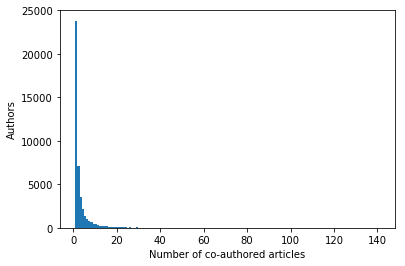

In [54]:
plt.hist(list(C_CoA.values()), bins=max(C_CoA.values()))
plt.xlabel("Number of co-authored articles")
plt.ylabel("Authors");

### Top co-authors

In [55]:
auth_coresp=pd.read_csv(path + "/authors.csv", encoding = "ISO-8859-1")

In [56]:
auth_coresp.head()

,original,uniformat,equivalent
0,&Lubos Pástor,&Lubos Pástor,"['&Lubos Pástor', 'Lubos Pástor']"
1,"Hao, (Grace) Qing",(Grace) Qing Hao,"['Hao, (Grace) Qing']"
2,1816-1906,1816-1906,['1816-1906']
3,"Kalay, A",A Kalay,"['Kalay, A']"
4,"Auquier, A A",A A Auquier,"['Auquier, A A']"


In [57]:
# List authors who authored at least "tsh" articles
tsh=60
top_CoA=list({k: v for k, v in C_CoA.items() if v > tsh}.keys())
auth_coresp.loc[top_CoA]

,original,uniformat,equivalent
908,Alan J. Auerbach,Alan J. Auerbach,"['Alan J. Auerbach', 'Auerbach, Alan J', 'Auer..."
1061,Alberto Alesina,Alberto Alesina,"['Alberto Alesina', 'Aleberto Alesina', 'Alesi..."
1629,"Meltzer, Allan H.",Allan H. Meltzer,"['Meltzer, Allan H.', 'Allan H. Meltzer', 'Mel..."
1740,Alvin E. Roth,Alvin E. Roth,"['Alvin E. Roth', 'AlvinE. Roth', 'Roth, Alvin..."
2217,"Shleifer, Andrei",Andrei Shleifer,"['Shleifer, Andrei', 'Andrei Shleifer', 'Shlei..."
3472,"Razin, Assaf",Assaf Razin,"['Razin, Assaf', 'Assaf Razin']"
7345,"Smith, Clifford JR.",Clifford JR. Smith,"['Smith, Clifford JR.', 'Smith, Clifford Jr.']"
8383,Daron Acemoglu,Daron Acemoglu,"['Daron Acemoglu', 'Acemoglu, Daron']"
8578,David Card,David Card,"['David Card', 'Card, David']"
9322,"Ray, Debraj",Debraj Ray,"['Ray, Debraj', 'Debraj Ray']"


### Search author

In [58]:
# To look for a given author
def search_auth(auth_name):
    
    resp_auth=auth_coresp.index[auth_coresp.uniformat.str.contains(auth_name)]
    for i in resp_auth:
        print(auth_coresp.uniformat[i],C_CoA[i])

In [59]:
search_auth("Friedman")

Barry L Friedman 1
Benjamin M. Friedman 41
Bernard Friedman 3
Craig Friedman 2
D. Friedman 1
Daniel Friedman 27
David D Friedman 6
David Friedman 1
David M. Friedman 2
Eric Friedman 3
Eric J. Friedman 1
Harris C. Friedman 1
Henry L. Friedman 1
Irving S. Friedman 1
J. W. Friedman 2
James W. Friedman 11
Jed Friedman 2
John Friedmann 1
John N. Friedman 9
Jorge Friedman 1
Joseph Friedman 4
Milton Friedman 46
Philip Friedman 1
Ralph Friedmann 2
Richard B. Friedman 1
Richard M  Friedman 1
Willa H. Friedman 1
